# Event segmentation and alignment in fMRI data

Author: Christopher Baldassano ([c.baldassano@columbia.edu](mailto:c.baldassano@columbia.edu))

## Overview
Humans tend to segment continuous perceptual experiences into discrete events. We have devised this notebook to capture the neural representations of this "chunking" process using a Hidden Markov Models (HMM). The notebook uses real data from naturalistic movie viewing and recall, suggesting ways to align derived neural event states with subjective annotations of event boundaries and with the recall time series.

## Annotated Bibliography
1. Baldassano, C., Chen, J., Zadbood, A., Pillow, J. W., Hasson, U., & Norman, K. A. (2017). Discovering event structure in continuous narrative perception and memory. *Neuron*, 95(3), 709–721.e5. [`link`](https://doi.org/10.1016/j.neuron.2017.06.041) *Describes and validates the event segmentation method, and applies it to perception and recall data from multiple experiments.*

2. Baldassano, C., Hasson, U., & Norman, K. A. (2018). Representation of real-world event schemas during narrative perception. *Journal of Neuroscience*, 38(45), 9689–9699. [`link`](https://doi.org/10.1523/JNEUROSCI.0251-18.2018) *Uses the event segmentation model to find common event structure among narratives with a shared schematic script.*

3. Ben-Yakov, A., & Henson, R. N. (2018). The hippocampal film editor: sensitivity and specificity to event boundaries in continuous experience. *Journal of Neuroscience*, 38(47), 10057–10068. [`link`](https://doi.org/10.1523/JNEUROSCI.0524-18.2018) *Further studies the relationship between the event boundaries produced by the event segmentation model, human-annotated boundaries, and hippocampal responses.*

4. Silva, M., Baldassano, C., & Fuentemilla, L. (2019). Rapid memory reactivation at movie event boundaries promotes episodic encoding. *Journal of Neuroscience*, 39(43), 8538–8548. [`link`](https://doi.org/10.1523/JNEUROSCI.0360-19.2019) *Applies the event segmentation model to EEG signals collected while subjects were watching a movie.*

5. Antony, J. W., Hartshorne, T. H., Pomeroy, K., Gureckis, T. M., Hasson, U., McDougle, S. D., & Norman, K. A. (2020). Behavioral, physiological, and neural signatures of surprise during naturalistic sports viewing. *Neuron*. [`link`](https://doi.org/10.1016/j.neuron.2020.10.029) *Uses the event segmentation model to relate the number and timing of event boundaries in neural signals  to the degree of surprise elicited in basketball games.*

## Table of Contents
* [](#loading-data)
* [](#finding-event-boundaries-during-perception)
* [](#comparing-model-and-human-labeled-boundaries)
* [](#aligning-movie-and-recall-data)
* [](#summary)

In [1]:
import warnings
import sys 
import os    
import glob
from functools import reduce
import numpy as np
from brainiak.eventseg.event import EventSegment
from scipy.stats import norm

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

smallsize=14; mediumsize=16; largesize=18
plt.rc('xtick', labelsize=smallsize); plt.rc('ytick', labelsize=smallsize); plt.rc('legend', fontsize=mediumsize)
plt.rc('figure', titlesize=largesize); plt.rc('axes', labelsize=mediumsize); plt.rc('axes', titlesize=mediumsize)

## Loading data
This tutorial will use data from the first run of the Sherlock dataset [(Chen et al. 2017)](https://doi.org/10.1038/nn.4450), masked to only include the Angular Gyrus.

In [2]:
if not os.path.exists('Sherlock_AG_movie.npy'):
    !wget https://ndownloader.figshare.com/files/22927253 -O Sherlock_AG_movie.npy
if not os.path.exists('Sherlock_AG_recall.npy'):
    !wget https://ndownloader.figshare.com/files/22927256 -O Sherlock_AG_recall.npy

movie = np.load('Sherlock_AG_movie.npy')
recall = np.load('Sherlock_AG_recall.npy')
movie_group = np.mean(movie, axis=0)

In [3]:
movie.shape, recall.shape, movie_group.shape

((16, 946, 4230), (487, 4230), (946, 4230))

## Finding event boundaries during perception

### Warm-up: Event structure in activity patterns

Before applying any model, a good first step is to plot the correlation between activity patterns for each pair of timepoints during the movie. In this dataset, this shows blocks along the diagonal, which indicates that activity patterns are remaining stable for periods of tens of timepoints. This is the kind of structure that the HMM will be looking for.

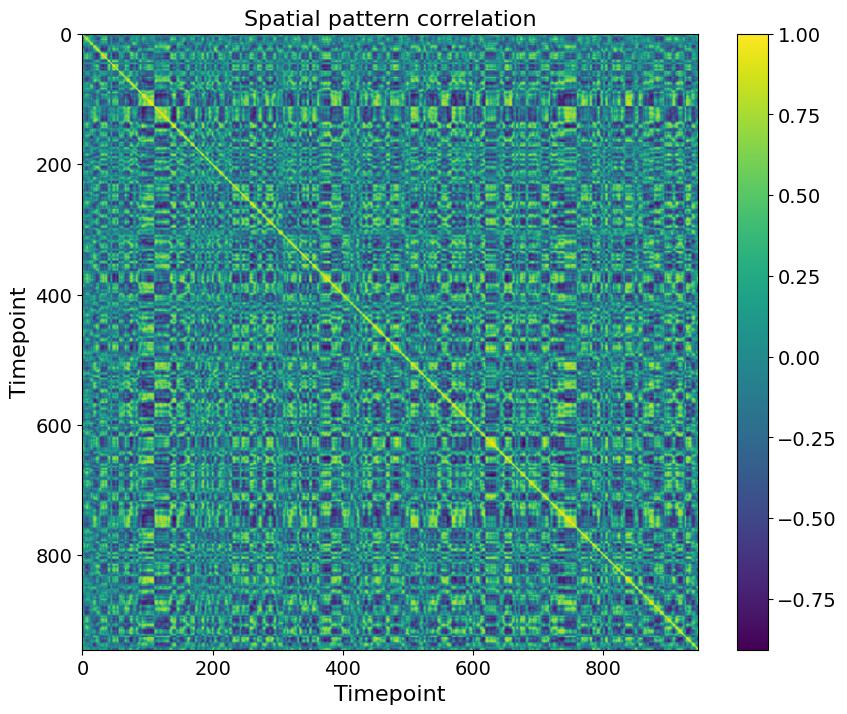

In [4]:
plt.figure(figsize=(10,8))
plt.imshow(np.corrcoef(movie_group))
plt.xlabel('Timepoint')
plt.ylabel('Timepoint')
plt.colorbar()
plt.title('Spatial pattern correlation');

### Fitting the HMM

To use an HMM to find both the event timings and the patterns corresponding to each event, we can use the EventSegment class from the brainiak toolbox. We need to specify the number of events, which here we set to 29 (corresponding to the number of boundaries typically annotated by human subjects).

In [10]:
movie_HMM = EventSegment(n_events = 29)
movie_HMM.fit(movie_group);

This fit produces:
* The log-likelihood (measuring overall model fit) over training. (Note that the log-likelihood on held-out test data is often a better measure of model quality - see below).
* The mean voxel pattern for each event. Here we show only 1% of the voxels since the ROI is large.
* A matrix showing the probability of being in each event at each timepoint. We can use this to derive the most likely timepoints where boundaries occur, and plot these on top of the timepoint similarity matrix for comparison.

Text(0.5, 0, 'Model fitting steps')

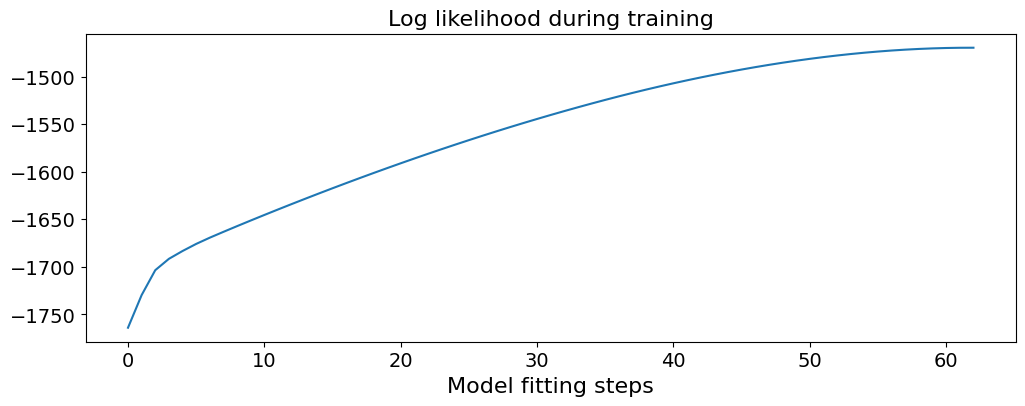

In [11]:
# Plotting the log-likelihood (measuring overall model fit)
plt.figure(figsize = (12, 4))
plt.plot(movie_HMM.ll_)
plt.title('Log likelihood during training')
plt.xlabel('Model fitting steps')

Text(0, 0.5, 'Voxels')

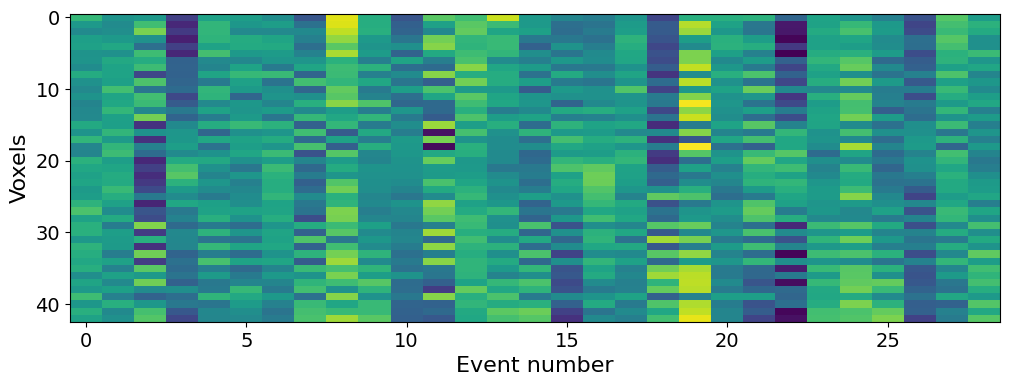

In [12]:
# Plotting mean activity in each event for some example voxels
plt.figure(figsize = (12, 4))
example_vox = np.arange(0,movie_HMM.event_pat_.shape[0],100)
plt.imshow(movie_HMM.event_pat_[example_vox,:], aspect='auto')
plt.xlabel('Event number')
plt.ylabel('Voxels')

Text(0.5, 1.0, 'Event probability')

<Figure size 1200x600 with 0 Axes>

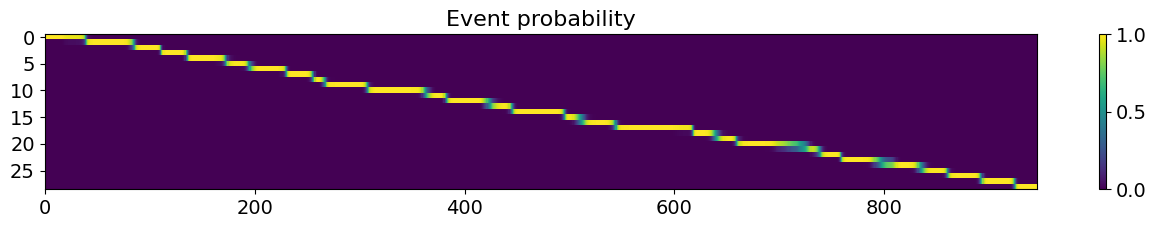

In [13]:
# Plot probability of being in each event at each timepoint
plt.figure(figsize = (12, 6))
plt.matshow(movie_HMM.segments_[0].T, aspect='auto')
plt.gca().xaxis.tick_bottom()
plt.colorbar()
plt.title('Event probability')

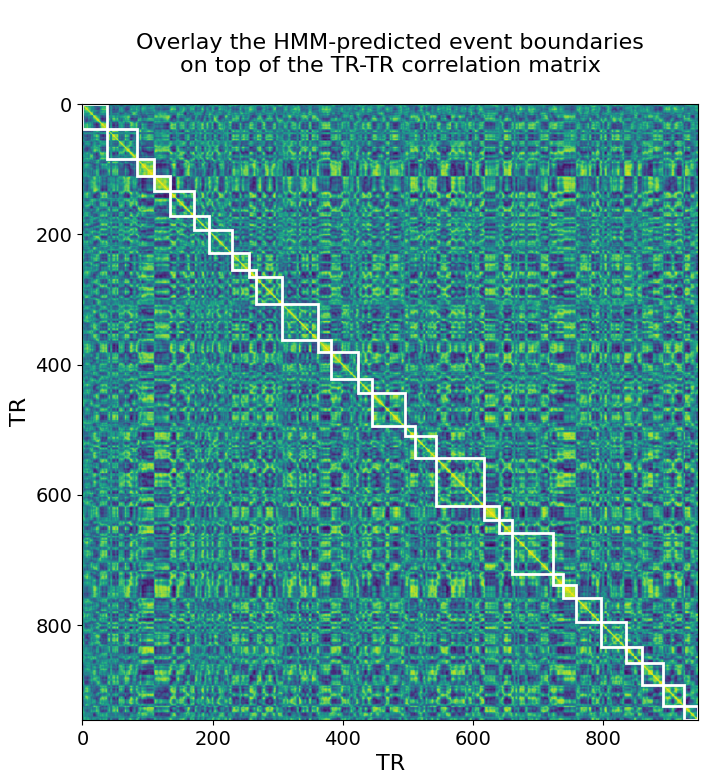

In [14]:
# Identify event boundaries as timepoints when max probability switches events
event_bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis = 1)))[0]
nTRs = movie_group.shape[0]


# Plot boundaries as boxes on top of timepoint correlation matrix
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    
    ax.imshow(np.corrcoef(data_matrix), cmap = 'viridis')
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0], bounds, [n_TRs]))
    
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i+1] - bounds_aug[i],
            bounds_aug[i+1] - bounds_aug[i],
            linewidth = 2, edgecolor = 'w',facecolor = 'none'
        )
        ax.add_patch(rect)


f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = '''
Overlay the HMM-predicted event boundaries
on top of the TR-TR correlation matrix
'''
plot_tt_similarity_matrix(ax, movie_group, event_bounds, nTRs, title_text)

### Determining the number of events with the HMM

What if we don't want to prespecify the number of events, but instead want to determine the number of events from the data? One way to determine the best number of events is to fit the model on a training set and then test the model fit on independent subjects.

In [15]:
k_array = np.arange(20, 61, 10)
test_ll = np.zeros(len(k_array))

for i, k in enumerate(k_array):
    print('Trying %d events' % k)
    
    print('   Fitting model on training subjects...')
    movie_train = np.mean(movie[:8], axis = 0)
    movie_HMM = EventSegment(k)
    movie_HMM.fit(movie_train)
    
    print('   Testing model fit on held-out subjects...')
    movie_test = np.mean(movie[8:], axis = 0)
    _, test_ll[i] = movie_HMM.find_events(movie_test)

Trying 20 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 30 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 40 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 50 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 60 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...


Text(0.5, 0, 'Average event length (sec)')

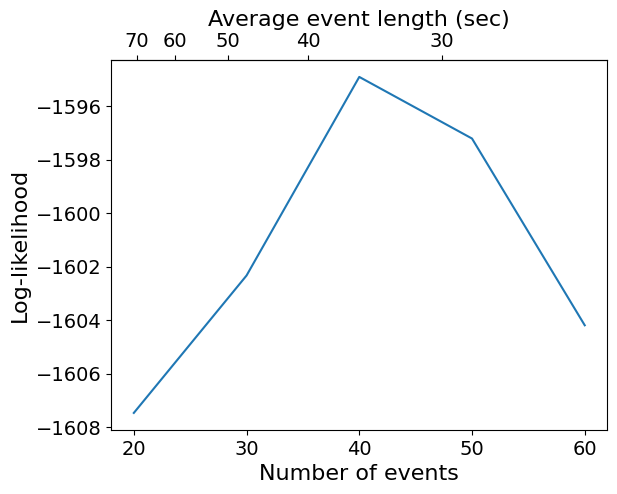

In [16]:
plt.plot(k_array, test_ll)
plt.xlabel('Number of events')
plt.ylabel('Log-likelihood')

movie_dur = nTRs * 1.5  # Data acquired every 1.5 seconds
secax = plt.gca().secondary_xaxis('top',
                                  functions=(lambda x: movie_dur / (x + sys.float_info.epsilon),
                                             lambda x: movie_dur / (x + sys.float_info.epsilon)))
secax.set_xlabel('Average event length (sec)')

### Optimal segmentation with the HMM
Since 40 events maximized the test log-likelihood, we'll generate two versions of HMM boundaries using 40 events. In addition to the "vanilla" HMM, we'll run an HMM with more flexibility during fitting (allowing for split-merge operations). This is slower (and so should usually only be used for generating a final segmentation), but can produce better fits if events are very uneven in duration. We will use these segmentations below for comparison with human labeled event boundaries.

In [11]:
print('Fitting HMM with 40 events...')
HMM40 = EventSegment(n_events = 40)
HMM40.fit(movie_group)
HMM40_bounds = np.where(np.diff(np.argmax(HMM40.segments_[0], axis = 1)))[0]

print('Fitting split-merge HMM with 40 events...')
HMM40_SM = EventSegment(n_events = 40, split_merge = True)
HMM40_SM.fit(movie_group)
HMM40_SM_bounds = np.where(np.diff(np.argmax(HMM40_SM.segments_[0], axis = 1)))[0]

Fitting HMM with 40 events...
Fitting split-merge HMM with 40 events...


## Comparing model and human-labeled boundaries

We can also quantitatively compare the event boundaries between different models, or between a model and human-labeled event boundaries. Because there is some ambiguity in both the stimulus and the model about exactly which timepoint the transition occurs at, we will count two boundaries as being a "match" if they are within 3 TRs (4.5 seconds) of each other.

To determine whether the match is statistically significant, we generate permuted versions of the boundaries as a null model for comparison.

In [12]:
# Timepoints of event boundaries annotated by human raters
human_bounds = [
    26, 35, 56, 72, 86, 108, 131, 143, 157, 173, 192, 204, 
    226, 313, 362, 398, 505, 526, 533, 568, 616, 634, 678,
    696, 747, 780, 870, 890
]

In [13]:
# Computes fraction of ground truth bounds that are covered by a set of proposed bounds
# Returns z score relative to a null distribution via permutation
def match_z(proposed_bounds, gt_bounds, num_TRs):
    nPerm = 1000
    threshold = 3
    np.random.seed(0)

    gt_lengths = np.diff(np.concatenate(([0],gt_bounds,[num_TRs])))
    match = np.zeros(nPerm + 1)
    for p in range(nPerm + 1):
        gt_bounds = np.cumsum(gt_lengths)[:-1]
        for b in gt_bounds:
            if np.any(np.abs(proposed_bounds - b) <= threshold):
                match[p] += 1
        match[p] /= len(gt_bounds)
        gt_lengths = np.random.permutation(gt_lengths)
    
    return (match[0]-np.mean(match[1:]))/np.std(match[1:])

z = [match_z(HMM40_bounds, human_bounds, nTRs),
     match_z(HMM40_SM_bounds, human_bounds, nTRs)]

print('HMM40:    z = %f, p = %f' % (z[0], norm.sf(z[0])))
print('HMM_SM40: z = %f, p = %f' % (z[1], norm.sf(z[1])))

HMM40:    z = 2.989227, p = 0.001398
HMM_SM40: z = 3.454808, p = 0.000275


## Aligning movie and recall data

A simple model of free recall is that a subject will revisit the same sequence of events experienced during perception, but the lengths of the events will not be identical between perception and recall. We use the same fit function as for a single dataset, but now we pass in both the movie and recall datasets in a list. We assume the two datasets have shared event transitions.

In [14]:
movie_recall_HMM = EventSegment(40)
movie_recall_HMM.fit([movie_group, recall]);

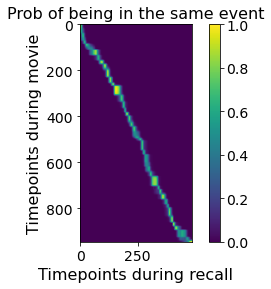

In [15]:
plt.imshow(movie_recall_HMM.segments_[0] @ movie_recall_HMM.segments_[1].T)
plt.xlabel('Timepoints during recall')
plt.ylabel('Timepoints during movie')
plt.colorbar()
plt.title('Prob of being in the same event');

## Summary
Using the HMM, we first captured neural states corresponding with the naturalistic segmentation of events. Then, to verify that these states aligned with subjective event perception, we aligned their boundaries with event boundary annotations from an independent group of subjects. Finally, we showed that processes such as free recall, which feature similar transition structures but may be compressed or expanded in time, can be aligned to this perceptual HMM "template", broadening the scope of future research questions that can be addressed with this technique.